In [36]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)
print(torch.__version__)

2.20.0
2.5.0


In [4]:
# Set random seeds for reproducibility
tf.random.set_seed(42)

torch.manual_seed(42)

np.random.seed(42)

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.0


In [6]:
train_df = pd.read_csv('Data/train.csv', index_col=0)
val_df = pd.read_csv('Data/val.csv', index_col=0)
test_df = pd.read_csv('Data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# Creating windows of data

## Exploring how deep learning models are trained for time series forecasting

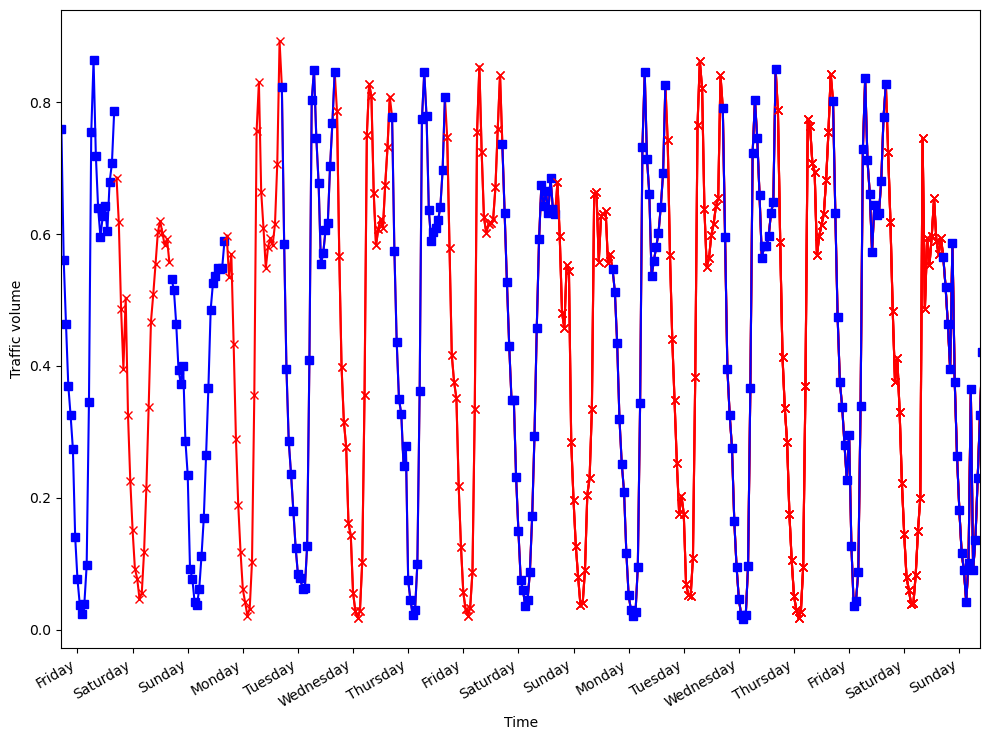

In [31]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# Visualizing the data windows on the training set. The inputs are shown with square 
# markers, and the labels are shown with crosses. Each data window consists of 24 timesteps with 
# square markers followed by 24 labels with crosses.

## Implementing the DataWindow class

In [57]:
# The class is based on the width of the input, the width of the label, and the shift.
# The width of the input is simply the number of timesteps that are fed into the model
# to make predictions. For example, given that we have hourly data in our dataset, if we
# feed the model with 24 hours of data to make a prediction, the input width is 24. If we
# feed only 12 hours of data, the input width is 12. 

# The label width is equivalent to the number of timesteps in the predictions. If we
# predict only one timestep, the label width is 1. If we predict a full day of data (with
# hourly data), the label width is 24. 

# Finally, the shift is the number of timesteps separating the input and the predictions.
# If we predict the next timestep, the shift is 1. If we predict the next 24 hours
# (with hourly data), the shift is 24.

# tensorflow
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [68]:
# Pytortch
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length, target_columns=None , stride=1):
        self.data = torch.FloatTensor(data.values if hasattr(data, 'values') else data)
        self.sequence_length = sequence_length
        self.target_columns = target_columns
        self.stride = stride
        
        # Calculate valid starting indices
        self.indices = list(range(0, len(self.data) - sequence_length + 1, stride))
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        sequence = self.data[start_idx:start_idx + self.sequence_length]
        return sequence

class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None, batch_size=32):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # Name of the column that we wish to predict
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}  # Create a dictionary with the name and index of the label column. This will be used for plotting.
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # Create a dictionary with the name and index of each column. This will be used to separate the features from the target variable.
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width) # The slice function returns a slice object that specifies how to slice a sequence. In this case, it says that the input slice starts at 0 and ends when we reach the input_width.
        self.input_indices = np.arange(self.total_window_size)[self.input_slice] # Assign indices to the inputs. These are useful for plotting.
        
        self.label_start = self.total_window_size - self.label_width # Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
        self.labels_slice = slice(self.label_start, None) # The same steps that were applied for the inputs are applied for labels.
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] # Slice the window to get the inputs using the input_slice defined in __init__.
        labels = features[:, self.labels_slice, :] # Slice the window to get the labels using the labels_slice defined in __init__.
        
        if self.label_columns is not None: # if we have more than one target, we stack the labels.
            label_indices = [self.column_indices[name] for name in self.label_columns]
            labels = labels[:, :, label_indices]
            
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index].detach().numpy(),
                     label='Inputs', marker='.', zorder=-10) # Plot the inputs. They will appear as a continuous blue line with dots.

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index].detach().numpy(),
                        edgecolors='k', marker='s', label='Labels', c='green', s=64) # Plot the labels or actual values. They will appear as green squares.
            
            if model is not None:
                with torch.no_grad():
                    predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index].detach().numpy(),
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64) #  Plot the predictions. They will appear as red crosses.

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
    
    def make_dataset(self, data):
        dataset = TimeSeriesDataset(data, self.total_window_size, stride=1)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Create a mapped dataloader
        def mapped_dataloader():
            for batch in dataloader:
                yield self.split_to_inputs_labels(batch)
        
        return mapped_dataloader()
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

# Applying baseline models

## Single-step baseline model

In [69]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [59]:
# Tensorflow
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [60]:
# TF
column_indices = {name: i for i, name in enumerate(train_df.columns)} # Generate a dictionary with the name and index of each column in the training set.

baseline_last = Baseline(label_index=column_indices['traffic_volume']) # Pass the index of the target column in the Baseline class.

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()]) # Compile the model to generate the predictions.

In [61]:
val_performance = {} # Create a dictionary to hold the MAE of a model on the validation set.
performance = {} # Create a dictionary to hold the MAE of a model on the test set.

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0133 - mean_absolute_error: 0.0831


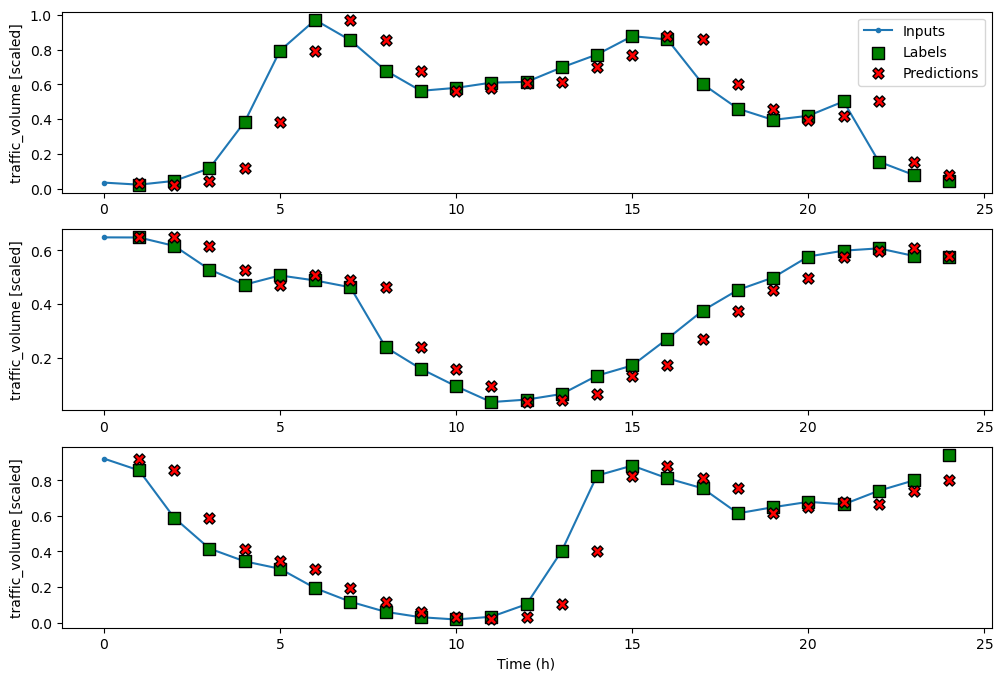

In [62]:
wide_window.plot(baseline_last)

In [15]:
print(performance['Baseline - Last'][1])

0.08128398656845093


In [70]:
# Pytorch
# Baseline Models
class Baseline(nn.Module):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def forward(self, inputs):
        if self.label_index is None: # If no target is specified, we return all columns. This is useful for multi-output models where all columns are to be predicted.
            return inputs
        
        elif isinstance(self.label_index, list): # If we specify a list of targets, it will return only the specified columns. Again, this is used for multi-output models.
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result.unsqueeze(-1)
                tensors.append(result)
            return torch.cat(tensors, dim=-1)
        
        result = inputs[:, :, self.label_index] # Return the input for a given target variable.
        return result.unsqueeze(-1)

In [71]:
# Pytorch
# Column indices
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Single-step baseline
baseline_last = Baseline(label_index=column_indices['traffic_volume'])
criterion = nn.MSELoss()

In [72]:
# Evaluation functions pytorch
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_mae = 0
    num_batches = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            mae = torch.mean(torch.abs(predictions - labels))
            
            total_loss += loss.item()
            total_mae += mae.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_mae = total_mae / num_batches
    
    return avg_loss, avg_mae

In [73]:
val_performance = {}
performance = {}

# Evaluate single-step baseline
val_loss, val_mae = evaluate_model(baseline_last, single_step_window.val, criterion)
test_loss, test_mae = evaluate_model(baseline_last, single_step_window.test, criterion)

val_performance['Baseline - Last'] = (val_loss, val_mae)
performance['Baseline - Last'] = (test_loss, test_mae)

print(f"Single-step Baseline - Test MAE: {test_mae:.6f}")

Single-step Baseline - Test MAE: 0.081326


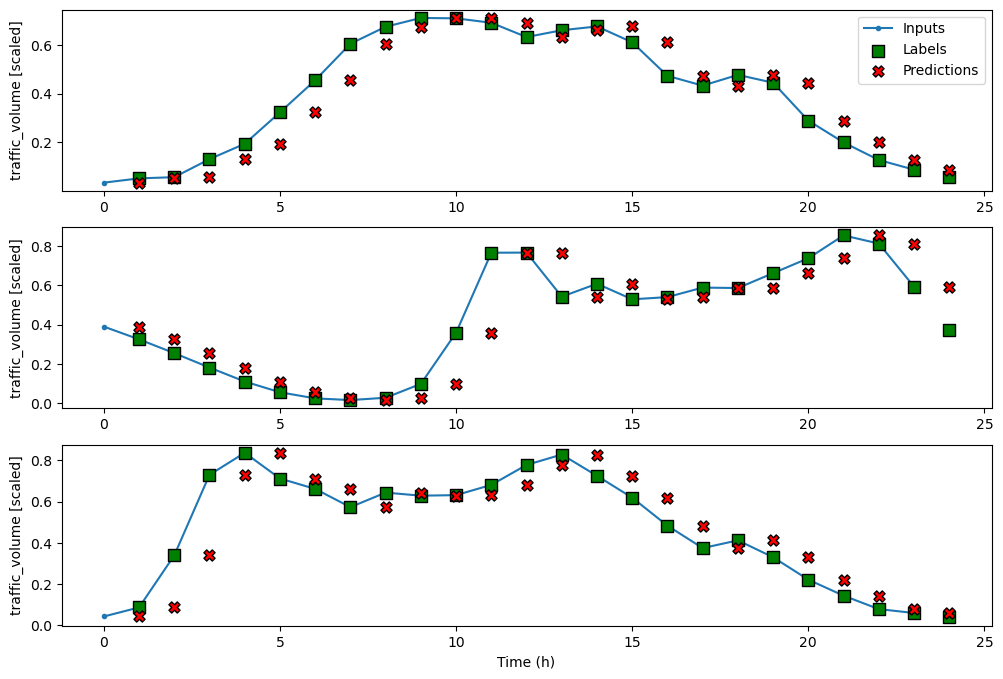

In [74]:
wide_window.plot(baseline_last)

## Multi-step baseline models

In [75]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

### Predicting the last known value

In [77]:
# Tensoorflow
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None: 
            return tf.tile(inputs[:, -1:, :], [1, 24, 1]) # If no target is specified, return the last known value of all columns over the next 24 timesteps.
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1]) # Return the last known value of the target column over the next 24 timesteps.

In [18]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.1873 - mean_absolute_error: 0.3520


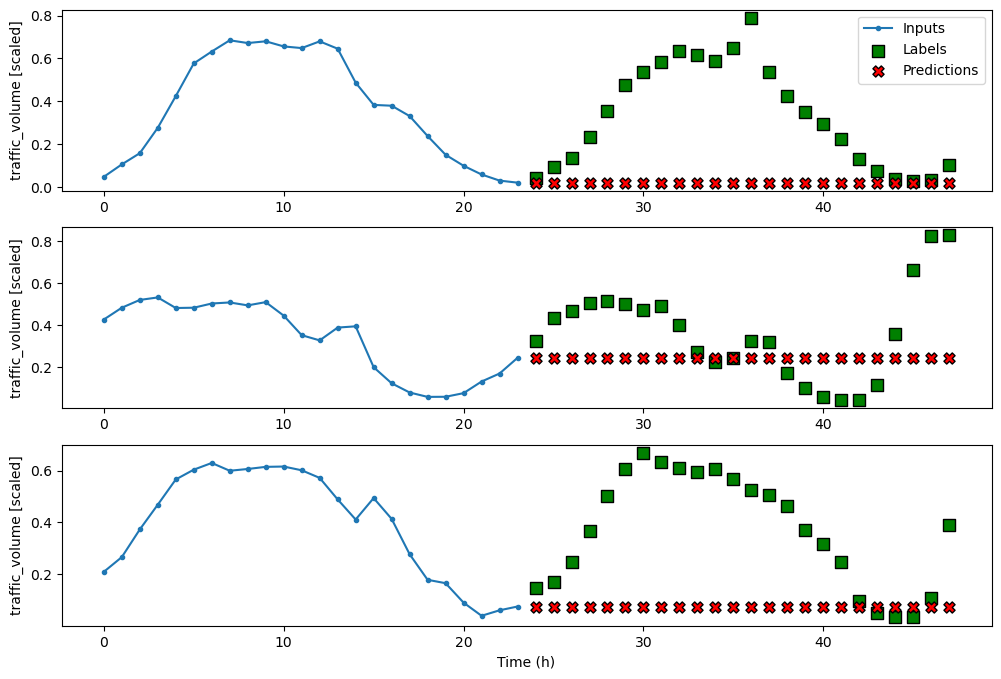

In [19]:
multi_window.plot(ms_baseline_last)

In [20]:
print(ms_performance['Baseline - Last'][1])

0.34701675176620483


In [78]:
# Pytorch
class MultiStepLastBaseline(nn.Module):
    def __init__(self, label_index=None, output_steps=24):
        super().__init__()
        self.label_index = label_index
        self.output_steps = output_steps
        
    def forward(self, inputs):
        if self.label_index is None:
            last_value = inputs[:, -1:, :]
            return last_value.repeat(1, self.output_steps, 1)
        
        if isinstance(self.label_index, list):
            last_values = inputs[:, -1:, self.label_index]
        else:
            last_values = inputs[:, -1:, self.label_index:self.label_index+1]
        
        return last_values.repeat(1, self.output_steps, 1)

In [79]:
# Multi-step baseline (last value)
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_val_performance = {}
ms_performance = {}

val_loss, val_mae = evaluate_model(ms_baseline_last, multi_window.val, criterion)
test_loss, test_mae = evaluate_model(ms_baseline_last, multi_window.test, criterion)

ms_val_performance['Baseline - Last'] = (val_loss, val_mae)
ms_performance['Baseline - Last'] = (test_loss, test_mae)

print(f"Multi-step Baseline (Last) - Test MAE: {test_mae:.6f}")

Multi-step Baseline (Last) - Test MAE: 0.302201


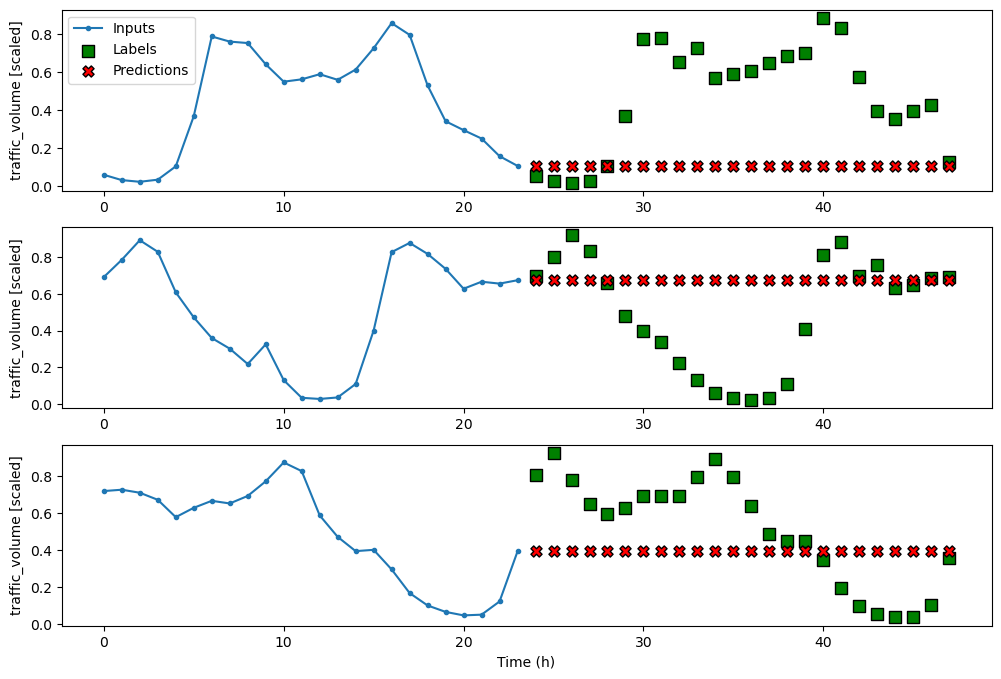

In [80]:
multi_window.plot(ms_baseline_last)

### Repeating the input sequence

In [85]:
# Tensorflow
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:] # Return the input sequence for the given target column.

In [22]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.2015 - mean_absolute_error: 0.3417


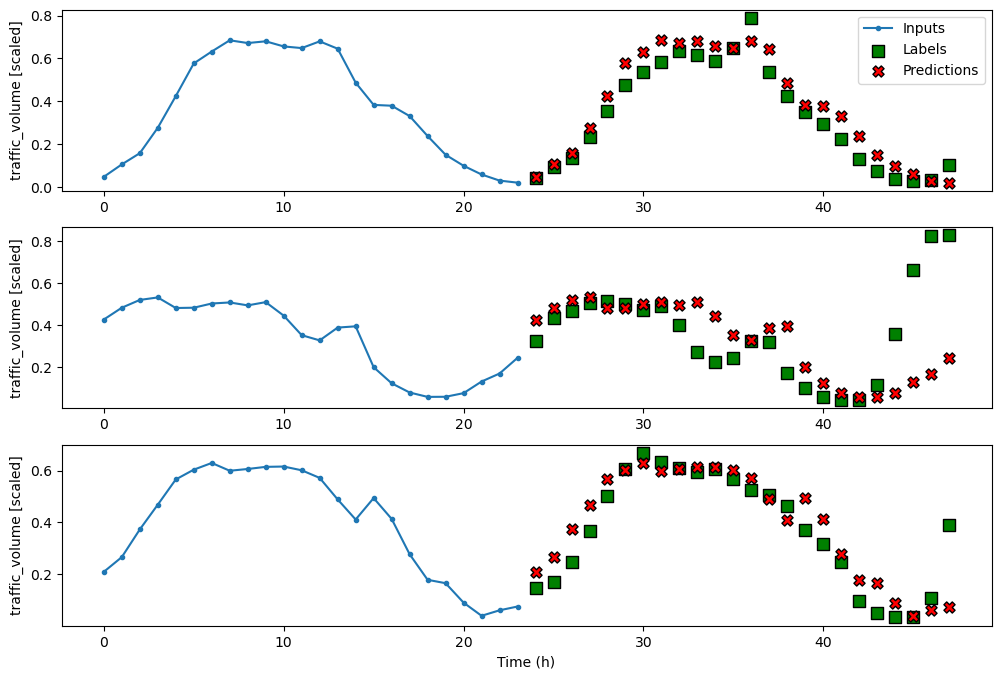

In [23]:
multi_window.plot(ms_baseline_repeat)

In [24]:
print(ms_performance['Baseline - Repeat'][1])

0.3326598107814789


In [86]:
# Pytorch
class RepeatBaseline(nn.Module):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def forward(self, inputs):
        if isinstance(self.label_index, list):
            return inputs[:, :, self.label_index]
        else:
            return inputs[:, :, self.label_index:]

In [83]:
# Multi-step baseline (repeat)
ms_baseline_repeat = RepeatBaseline(
    label_index=column_indices['traffic_volume']
)

val_loss, val_mae = evaluate_model(ms_baseline_repeat, multi_window.val, criterion)
test_loss, test_mae = evaluate_model(ms_baseline_repeat, multi_window.test, criterion)

ms_val_performance['Baseline - Repeat'] = (val_loss, val_mae)
ms_performance['Baseline - Repeat'] = (test_loss, test_mae)

print(f"Multi-step Baseline (Repeat) - Test MAE: {test_mae:.6f}")

Multi-step Baseline (Repeat) - Test MAE: 0.332686


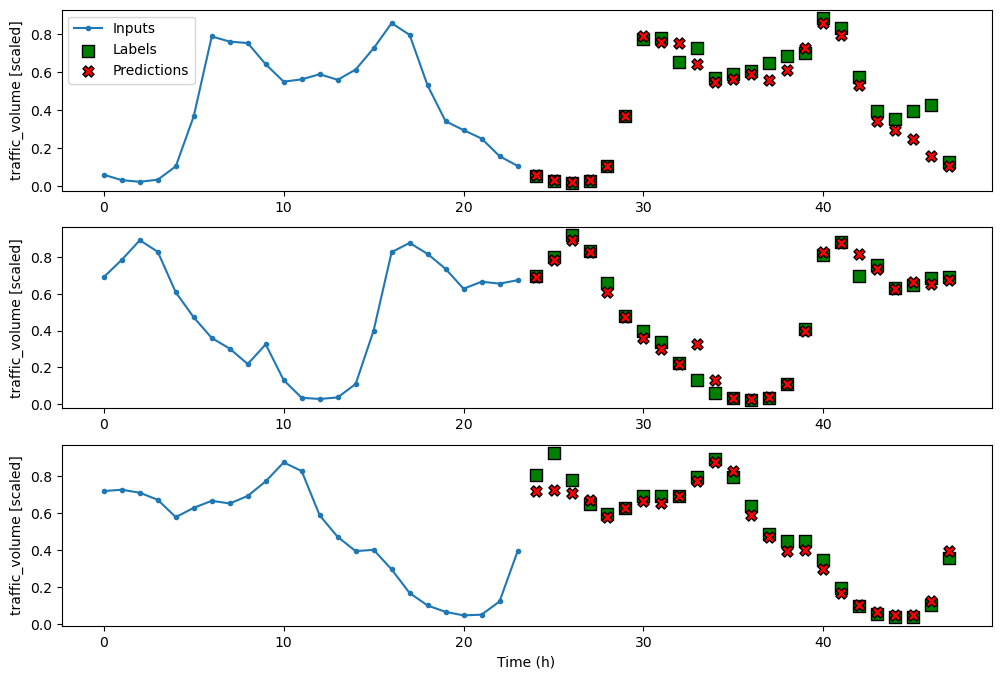

In [84]:
multi_window.plot(ms_baseline_repeat)

## Multi-output baseline model

In [87]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume']) 
# Notice that we pass in both temp and traffic_volume, as those are our two targets for the multi-output model.

In [88]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [27]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0069 - mean_absolute_error: 0.0482


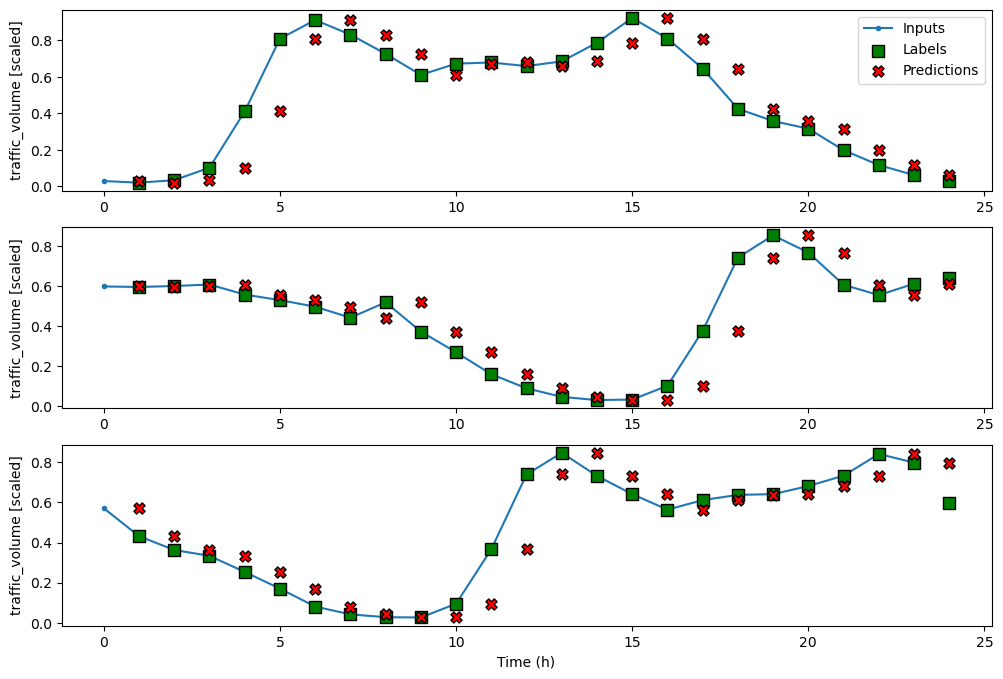

In [28]:
mo_wide_window.plot(mo_baseline_last)

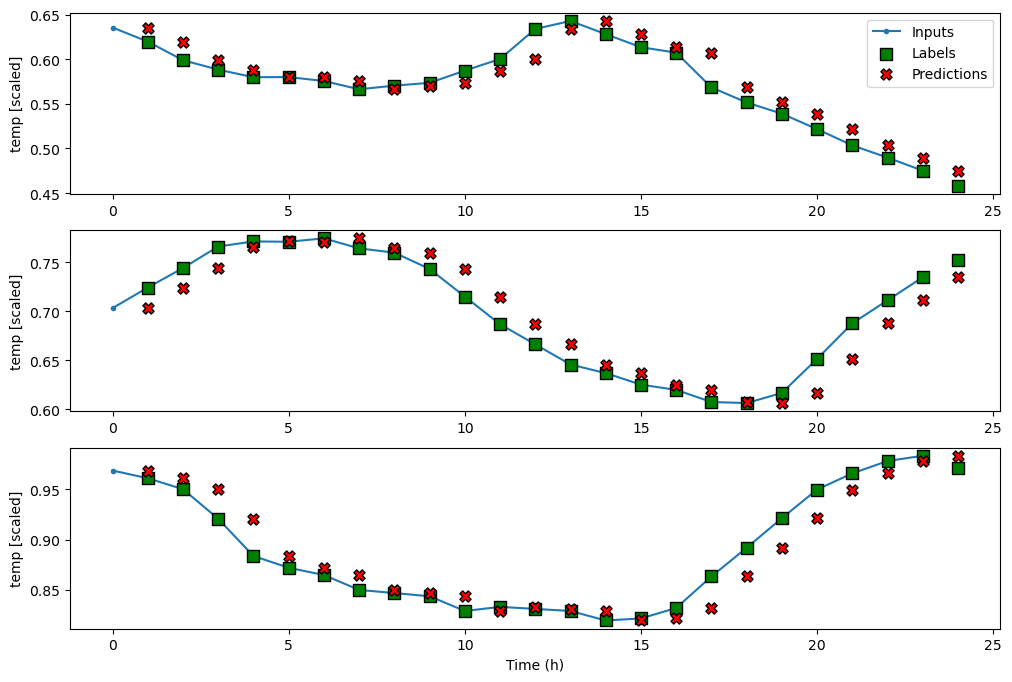

In [29]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [30]:
print(mo_performance['Baseline - Last'][1])

0.047106653451919556


In [90]:
# pytorch
# Multi-output baseline
mo_wide_window = DataWindow(
    input_width=24, label_width=24, shift=1, 
    label_columns=['temp', 'traffic_volume']
)

mo_baseline_last = Baseline(label_index=[0, 2])  # temp and traffic_volume

mo_val_performance = {}
mo_performance = {}

val_loss, val_mae = evaluate_model(mo_baseline_last, mo_wide_window.val, criterion)
test_loss, test_mae = evaluate_model(mo_baseline_last, mo_wide_window.test, criterion)

mo_val_performance['Baseline - Last'] = (val_loss, val_mae)
mo_performance['Baseline - Last'] = (test_loss, test_mae)

print(f"Multi-output Baseline - Test MAE: {test_mae:.6f}")

Multi-output Baseline - Test MAE: 0.047164


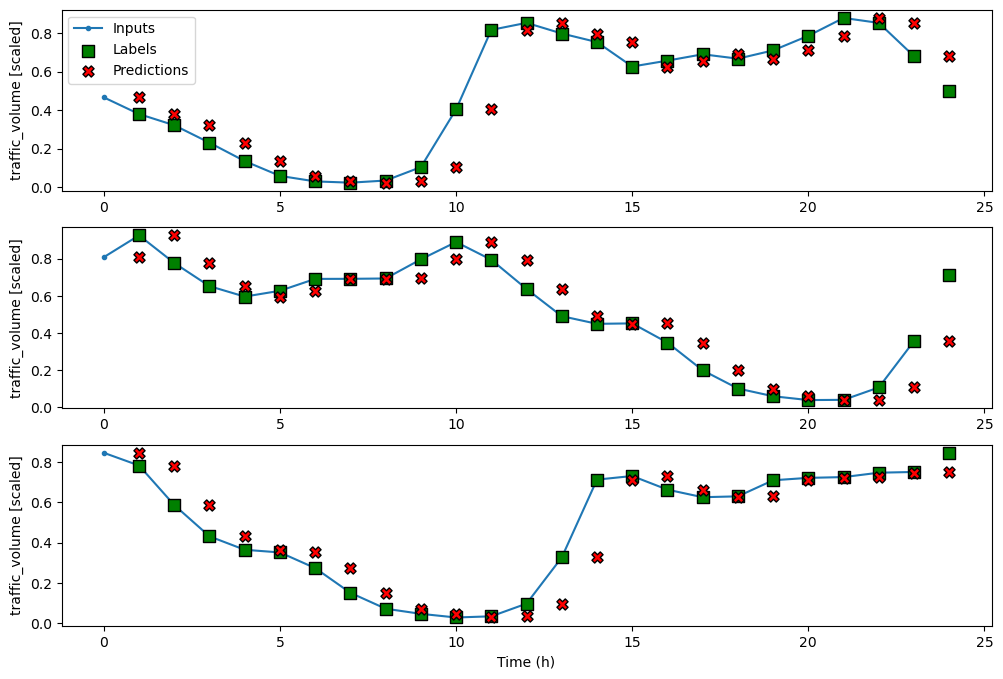

In [91]:
mo_wide_window.plot(mo_baseline_last)

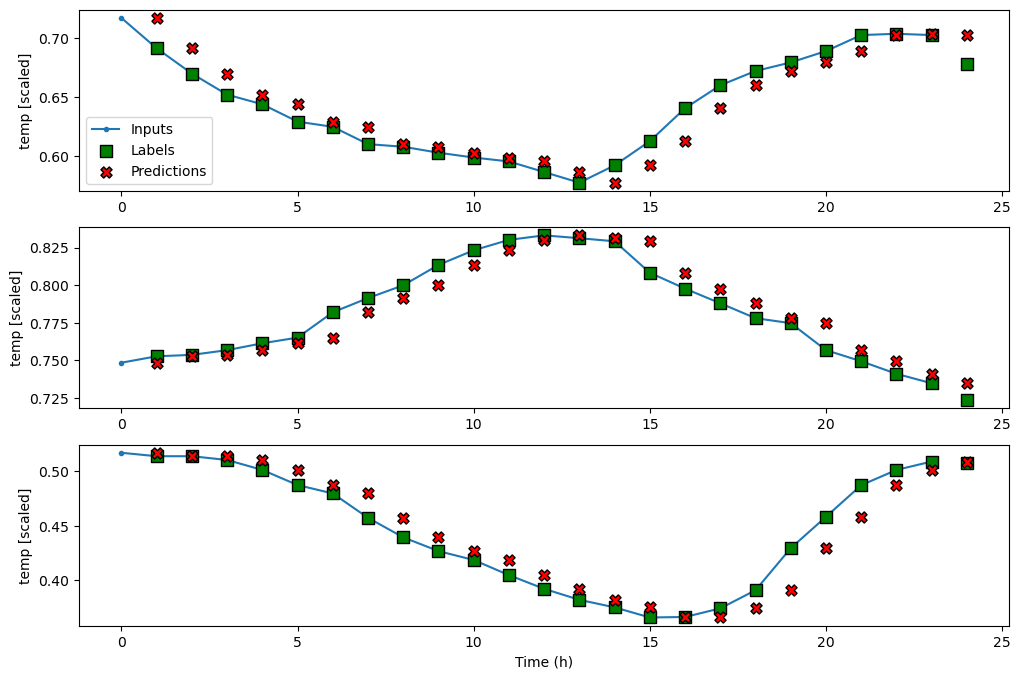

In [92]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')